In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Sep 27 11:30:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# <font color = red> <b> Project Computer Vision

###  <font color = teal> DOMAIN:
    
    Botanical research

### <font color = teal> CONTEXT : 

    University  X  is  currently  undergoing  some  research  involving  understanding  the  characteristics  of plant  and  plant  seedlings  at  various  stages  of  growth.  They  already  have  have  invested  on  curating  sample images. They require an automation which can create a classifier capable of determining a plant's species from a photo

### <font color = teal> DATA DESCRIPTION: 
    
    The dataset comprises of images from 12 plant species. Source: https://www.kaggle.com/c/plant-seedlings-classification/data

### <font color = teal> PROJECT  OBJECTIVE: 
    University’s  management  require  an  automation  which  can  create  a  classifier  capable  of determining a plant's species from a photo

### <font color = teal> Data Source: 
    
    https://drive.google.com/drive/folders/10Pk9PMfUOAPI3yTYZ6nvtwBA1CXRC9MG

# <font color = red> <b>Importing Packages

In [2]:
import tensorflow as tf
from tensorflow import keras 
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [28]:
missing_values = ["n/a", "na", "--","-"] 
import warnings
warnings.filterwarnings('ignore')
import numpy             as np
import pandas            as pd
pd.set_option('display.max_columns', 100)
import scipy.stats       as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn import metrics
from sklearn import svm
import sys
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, confusion_matrix  
from tensorflow.keras.models import load_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers,regularizers
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
from subprocess import check_output
import argparse
import glob
import cv2
import pathlib
import os.path
print(tf.__version__)
from pathlib import Path
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import CSVLogger

2.6.0


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# <b> Supervised Learning

In [ ]:
datagen = ImageDataGenerator()

In [ ]:
train_dir = '/content/drive/MyDrive/trainzip/train/'

In [ ]:
SPECIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen',
              'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse',
              'Small-flowered Cranesbill', 'Sugar beet']

for species in SPECIES:
    print('{} {} images'.format(species, len(os.listdir(os.path.join(train_dir, species)))))

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 671 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 384 images


In [ ]:
train = []

for species_num, species in enumerate(SPECIES):
    for file in os.listdir(os.path.join(train_dir, species)):
        train.append(['../content/drive/MyDrive/trainzip/train/{}/{}'.format(species, file), species_num, species])
        
train = pd.DataFrame(train, columns=['file', 'species_num', 'species'])

print('Training Data: ',train.shape)

Training Data:  (4766, 3)


#### Image Pre Processing 

In [ ]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [ ]:
%%time

x_train = []

for i in range(len(train)):
    img = cv2.imread(train['file'][i])
    img = cv2.resize(img,dsize=(256,256))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(256,256,1))
    x_train.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

CPU times: user 1min 19s, sys: 4.24 s, total: 1min 23s
Wall time: 30min 41s


In [ ]:
x_train1 = np.array(x_train)


In [ ]:
#### Displaying Sample Images 

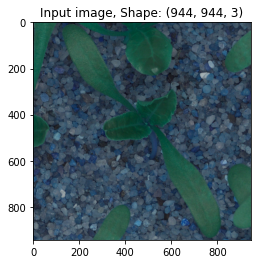

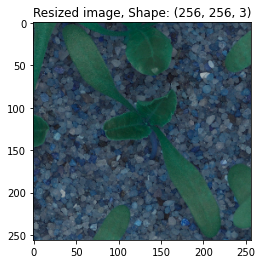

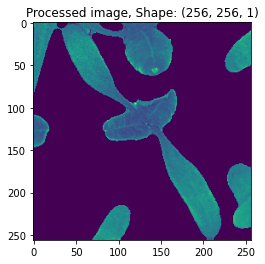

In [ ]:
# Input image
Input_image = cv2.imread(train['file'][len(train)-1])

plt.imshow(Input_image)
plt.title('Input image, Shape: '+str(Input_image.shape))
plt.show()

# Resized image
plt.imshow(img)
plt.title('Resized image, Shape: '+str(img.shape))
plt.show()
        
# Processed image to Stack
plt.imshow(np.reshape(img_stack,(256,256)))
plt.title('Processed image, Shape: '+str(img_stack.shape))
plt.show()



#### One-hot Encoding




In [ ]:
labels = train['species_num']
labels = keras.utils.to_categorical(labels, num_classes = len(SPECIES))

In [ ]:
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (256, 256, 4)


In [ ]:
from keras.layers.advanced_activations import LeakyReLU
def fire_incept(x, fire=16, intercept=64):
    x = Conv2D(fire, (5,5), strides=(2,2))(x)
    x = LeakyReLU(alpha=0.15)(x)
    
    left = Conv2D(intercept, (3,3), padding='same')(x)
    left = LeakyReLU(alpha=0.15)(left)
    
    right = Conv2D(intercept, (5,5), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)
    
    x = concatenate([left, right], axis=3)
    return x

def fire_squeeze(x, fire=16, intercept=64):
    x = Conv2D(fire, (1,1))(x)
    x = LeakyReLU(alpha=0.15)(x)
    
    left = Conv2D(intercept, (1,1))(x)
    left = LeakyReLU(alpha=0.15)(left)
    
    right = Conv2D(intercept, (3,3), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)
    
    x = concatenate([left, right], axis=3)
    return x

image_input=Input(shape=input_shape)

x = fire_incept((image_input), fire=16, intercept=16)

x = fire_incept(x, fire=32, intercept=32)
x = fire_squeeze(x, fire=32, intercept=32)

x = fire_incept(x, fire=64, intercept=64)
x = fire_squeeze(x, fire=64, intercept=64)

x = fire_incept(x, fire=64, intercept=64)
x = fire_squeeze(x, fire=64, intercept=64)

x = Conv2D(64, (3,3))(x)
x = LeakyReLU(alpha=0.1)(x)

x = Flatten()(x)

x = Dense(512)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.1)(x)

out = Dense(len(SPECIES), activation='softmax')(x)

In [ ]:
model_new = Model(image_input, out)
model_new.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 126, 126, 16) 1616        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_23 (LeakyReLU)      (None, 126, 126, 16) 0           conv2d_23[0][0]                  
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 126, 126, 16) 2320        leaky_re_lu_23[0][0]             
______________________________________________________________________________________________

#### Compiling the model

In [ ]:
model_new.compile(optimizer = Adam(lr=.00025) , loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, 
                                            factor=0.5, min_lr=0.00001)

#### Data Augumentation

In [ ]:
datagen = ImageDataGenerator(rotation_range=40, zoom_range = 0.2, width_shift_range=0.2, height_shift_range=0.2,
                             horizontal_flip=True, vertical_flip=True)
datagen.fit(x_train)

In [ ]:
batch_size = 32
epochs = 10

In [ ]:
history = model_new.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size), epochs = epochs,
                                  validation_data = (x_val,y_val), verbose = 1, 
                                  steps_per_epoch=x_train.shape[0] // batch_size, 
                                  callbacks=[learning_rate_reduction])

Epoch 1/10
134/134 [==============================] - 68s 505ms/step - loss: 1.7044 - accuracy: 0.3892 - val_loss: 1.3706 - val_accuracy: 0.5346
Epoch 2/10
134/134 [==============================] - 67s 500ms/step - loss: 1.4152 - accuracy: 0.4926 - val_loss: 1.4168 - val_accuracy: 0.4885
Epoch 3/10
134/134 [==============================] - 67s 500ms/step - loss: 1.3483 - accuracy: 0.5116 - val_loss: 1.0974 - val_accuracy: 0.6164
Epoch 4/10
134/134 [==============================] - 67s 500ms/step - loss: 1.1518 - accuracy: 0.5856 - val_loss: 1.0477 - val_accuracy: 0.6268
Epoch 5/10
134/134 [==============================] - 67s 500ms/step - loss: 1.1192 - accuracy: 0.6077 - val_loss: 1.0932 - val_accuracy: 0.6101
Epoch 6/10
134/134 [==============================] - 67s 501ms/step - loss: 1.1316 - accuracy: 0.5988 - val_loss: 0.7954 - val_accuracy: 0.7149
Epoch 7/10
134/134 [==============================] - 67s 499ms/step - loss: 0.9686 - accuracy: 0.6552 - val_loss: 0.8101 - val_ac

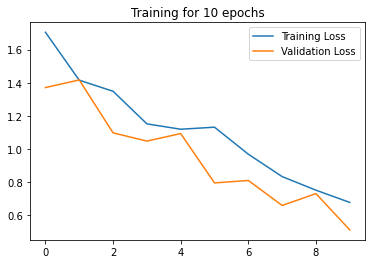

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [ ]:
score = model_new.evaluate(x_val,y_val)
print('Accuracy on Validation Set',score[1])

15/15 [==============================] - 0s 18ms/step - loss: 0.5118 - accuracy: 0.8239
Accuracy on Validation Set 0.8238993883132935


In [ ]:
model_feat = Model(inputs=model_new.input,outputs=model_new.get_layer('dense_2').output)

feat_train = model_feat.predict(x_train)
print(feat_train.shape)

feat_val = model_feat.predict(x_val)
print(feat_val.shape)

(4289, 512)
(477, 512)


#### Applying SVM

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')

svm.fit(feat_train,np.argmax(y_train,axis=1))

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
svm.score(feat_train,np.argmax(y_train,axis=1))

0.8957799020750757

#### Applying XGBOOST

In [ ]:
import xgboost as xgb

xb = xgb.XGBClassifier()

xb.fit(feat_train,np.argmax(y_train,axis=1))


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xb.score(feat_train,np.argmax(y_train,axis=1))

0.9906738167404989

#### Supervised Learning Summarry
- The XGBOOST model gives us an accuracy of 99% seems like an overfit as XG boost is a very powerful classifer 

# <b> Neural Network

In [11]:
ScaleTo = 70  # px to scale
seed = 7  # fixing random

path = '/content/drive/MyDrive/trainzip/train/*/*.png' 
files = glob.glob(path)

trainImg = []
trainLabel = []
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))  # Get image (with resizing)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set



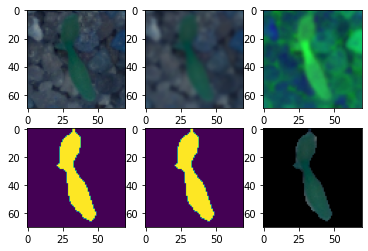

In [13]:
clearTrainImg = []
examples = []; getEx = True
for img in trainImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTrainImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

clearTrainImg = np.asarray(clearTrainImg)

**Now setting the values of input from [0...255] to [0...1] (RGB color-space encode colors with numbers [0...255]).**

In [14]:
clearTrainImg = clearTrainImg / 255

In [15]:
le = preprocessing.LabelEncoder()
le.fit(trainLabel[0])
print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(trainLabel[0])

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']


In [17]:
from keras.utils import np_utils
clearTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_clases))

Number of classes: 12


In [18]:
trainXX, testXX, trainYY, testYY = train_test_split(clearTrainImg, clearTrainLabel, 
                                                test_size=0.1, random_state=seed, 
                                                stratify = clearTrainLabel)

In [19]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(trainXX)

In [21]:
np.random.seed(seed)  # Fix seed

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(ScaleTo, ScaleTo, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_clases, activation='softmax'))

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 128)       2

In [22]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

In [37]:
# fit model
hist = model.fit_generator(datagen.flow(trainXX, trainYY, batch_size=75), 
                          epochs=35, validation_data=(testXX, testYY))

Epoch 1/35
58/58 [==============================] - 6s 98ms/step - loss: 1.9837 - accuracy: 0.3570 - val_loss: 12.9382 - val_accuracy: 0.1405
Epoch 2/35
58/58 [==============================] - 6s 98ms/step - loss: 1.7249 - accuracy: 0.4159 - val_loss: 10.1623 - val_accuracy: 0.0818
Epoch 3/35
58/58 [==============================] - 6s 98ms/step - loss: 1.5711 - accuracy: 0.4677 - val_loss: 12.5059 - val_accuracy: 0.0608
Epoch 4/35
58/58 [==============================] - 6s 98ms/step - loss: 1.3556 - accuracy: 0.5346 - val_loss: 12.9438 - val_accuracy: 0.0608
Epoch 5/35
58/58 [==============================] - 6s 98ms/step - loss: 1.2901 - accuracy: 0.5610 - val_loss: 15.2589 - val_accuracy: 0.0608
Epoch 6/35
58/58 [==============================] - 6s 98ms/step - loss: 1.1477 - accuracy: 0.6081 - val_loss: 14.1602 - val_accuracy: 0.0818
Epoch 7/35
58/58 [==============================] - 6s 99ms/step - loss: 1.1167 - accuracy: 0.6174 - val_loss: 8.1330 - val_accuracy: 0.0839
Epoch 8

The Validatoin Accuracy is 75%, we used a simple conolution bcoz of which our accuracy is low, we will use transfer learning as we have a relatively medium dataset, hence we will try training the data set using Transfer learing and hence, we will use Resnet152.

#<Font color = Red> Testing CNN with Resnet

In [ ]:
train_diropti_dir = Path('../content/drive/MyDrive/trainzip/train/')

In [ ]:
filepaths = list(train_diropti_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Labels')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Labels
0,../content/drive/MyDrive/trainzip/train/Loose ...,Loose Silky-bent
1,../content/drive/MyDrive/trainzip/train/Loose ...,Loose Silky-bent
2,../content/drive/MyDrive/trainzip/train/Small-...,Small-flowered Cranesbill


In [ ]:
# Separate in train and test data
train_df1, test_df1 = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)
print(train_df1.shape, test_df1.shape)

(4289, 2) (477, 2)


In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2)

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [ ]:
img_rows, img_cols = 224, 224
batch_size = 32
classes = image_df['Labels'].nunique()
classes

12

In [ ]:
train_df1.head()

,Filepath,Labels
2139,../content/drive/MyDrive/trainzip/train/Loose ...,Loose Silky-bent
1624,../content/drive/MyDrive/trainzip/train/Shephe...,Shepherds Purse
2706,../content/drive/MyDrive/trainzip/train/Small-...,Small-flowered Cranesbill
94,../content/drive/MyDrive/trainzip/train/Cleave...,Cleavers
1419,../content/drive/MyDrive/trainzip/train/Cleave...,Cleavers


In [ ]:
train_generator1 = train_datagen.flow_from_dataframe(
    dataframe = train_df1,
    x_col = "Filepath",
    y_col = "Labels",
    target_size = (img_rows, img_cols),
    batch_size = batch_size,
    subset = "training",
    shuffle = True,
    class_mode = "categorical"
)

Found 3432 validated image filenames belonging to 12 classes.


In [ ]:
val_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = "Filepath",
    y_col = "Labels",
    target_size = (img_rows, img_cols),
    batch_size = batch_size,
    subset = "validation",
    shuffle = False,
    class_mode = "categorical"
)

Found 857 validated image filenames belonging to 12 classes.


In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = "Filepath",
    y_col = "Labels",
    target_size = (img_rows, img_cols),
    batch_size = batch_size,
    shuffle = False,
    class_mode = "categorical"
)

Found 477 validated image filenames belonging to 12 classes.


In [ ]:
basemodel = tf.keras.applications.ResNet152V2(
    weights = "imagenet",
    input_shape = (img_rows, img_cols, 3),
    include_top = False
)
for layer in basemodel.layers:
    layer.trainable = False
x = basemodel.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
output = tf.keras.layers.Dense(classes, activation="softmax")(x)
model = tf.keras.Model(inputs = basemodel.inputs, outputs = output)
model.summary()

234561536/234545216 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
___________________________

#### Compiling Base Model with CNN (Resnet)

In [ ]:
model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_generator1,
    epochs = 60,
    validation_data = val_generator
)

Epoch 1/60
108/108 [==============================] - 98s 862ms/step - loss: 1.2962 - accuracy: 0.5565 - val_loss: 0.9499 - val_accuracy: 0.6639
Epoch 2/60
108/108 [==============================] - 90s 833ms/step - loss: 0.7361 - accuracy: 0.7383 - val_loss: 0.8037 - val_accuracy: 0.7060
Epoch 3/60
108/108 [==============================] - 90s 829ms/step - loss: 0.6212 - accuracy: 0.7721 - val_loss: 0.7186 - val_accuracy: 0.7573
Epoch 4/60
108/108 [==============================] - 91s 840ms/step - loss: 0.5634 - accuracy: 0.7960 - val_loss: 0.7630 - val_accuracy: 0.7270
Epoch 5/60
108/108 [==============================] - 88s 816ms/step - loss: 0.5209 - accuracy: 0.8156 - val_loss: 0.5953 - val_accuracy: 0.7900
Epoch 6/60
108/108 [==============================] - 90s 831ms/step - loss: 0.4822 - accuracy: 0.8284 - val_loss: 0.5796 - val_accuracy: 0.7830
Epoch 7/60
108/108 [==============================] - 89s 826ms/step - loss: 0.4695 - accuracy: 0.8284 - val_loss: 0.5202 - val_ac

In [ ]:
scores = model.evaluate(val_generator, verbose = 1)
print("Loss: {:.3f}".format(scores[0]))
print("Accuracy: {:.3f}".format(scores[1]))

27/27 [==============================] - 18s 677ms/step - loss: 0.6553 - accuracy: 0.8320
Loss: 0.655
Accuracy: 0.832


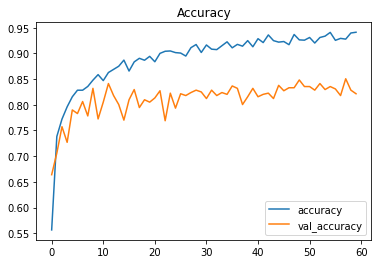

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

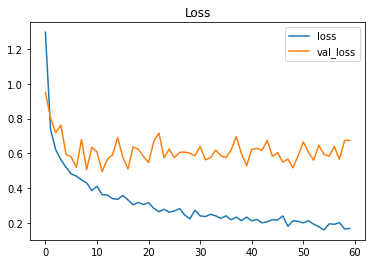

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
print("Accuracy on the test set: {:.2f}%".format(scores[1] * 100))

Accuracy on the test set: 83.20%


In [ ]:
test_pred = model.predict(test_generator, verbose=1)
test_labels = np.argmax(test_pred, axis=1)
test_labels[:10]

15/15 [==============================] - 8s 395ms/step


array([ 0,  6, 11,  3,  7, 10, 11,  1,  6,  8])

In [ ]:
class_labels = test_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}
classes = list(class_labels.values())
classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [ ]:
print("Classification Report")
print(classification_report(test_generator.classes, test_labels,target_names = classes))

Classification Report
                           precision    recall  f1-score   support

              Black-grass       0.70      0.64      0.67        25
                 Charlock       0.92      0.97      0.94        34
                 Cleavers       0.96      0.86      0.91        28
         Common Chickweed       0.90      0.95      0.92        63
             Common wheat       0.96      0.96      0.96        24
                  Fat Hen       0.91      0.87      0.89        46
         Loose Silky-bent       0.85      0.91      0.88        67
                    Maize       1.00      0.96      0.98        25
        Scentless Mayweed       0.82      0.96      0.88        48
          Shepherds Purse       0.80      0.59      0.68        27
Small-flowered Cranesbill       0.96      0.94      0.95        53
               Sugar beet       1.00      0.92      0.96        37

                 accuracy                           0.90       477
                macro avg       0.90  

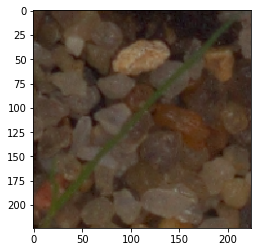

In [ ]:
img = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/trainzip/train/Loose Silky-bent/0012f11c4.png',
                                         target_size = (224, 224))
plt.imshow(img)

In [ ]:
img =tf.keras.preprocessing.image.img_to_array(img)
x = img/255
x = np.expand_dims(x, axis=0)
print(x.shape)

(1, 224, 224, 3)


In [ ]:
CLASS_NAMES = {
    'classes' :['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherd’s Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']
    }
prediction = model.predict(x)
predicted_c = np.argmax(prediction, axis=1)
predicted_c
predicted_class = CLASS_NAMES['classes'][predicted_c[0]]
print("This image is of :",predicted_class.upper())

This image is of : LOOSE SILKY-BENT


## CNN Model Summary: 
- <font color= teal>The Model used is Resent and this gives us an accuracy of 90% as per the classification report, and we can see that it has classified the image correctly as well. 
- We can obtain higher accuracy with more number of epochs and further tuning 
